In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('bmh')

# Methods

In [2]:
user_engagement  = pd.read_csv('takehome_user_engagement.csv')
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
# Preprocessing to row of dates and column of users with visit as counts
user_engagement['date'] = pd.to_datetime(user_engagement['time_stamp'], errors='coerce').dt.date
engagement = user_engagement.groupby(['user_id', 'date'])[['visited']].count()
engagement = engagement.unstack('date', fill_value=0).T

# Summing up 7-day visit
max_frequency = engagement.rolling(7).sum().fillna(0).apply(max).to_dict()
# Getting adopted user ids
adopted_users_list = [user for user in max_frequency if max_frequency[user]>3]

In [4]:
# Loading and preprocessing
users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1").drop(['last_session_creation_time'], axis=1)
users['adopted'] = users['object_id'].apply(lambda x: 1 if x in adopted_users_list else 0)
users['created_month'] = users['creation_time'].map(lambda x: x[5:7])
users['created_year'] = users['creation_time'].map(lambda x: x[0:4])

# Getting email host website
def get_domain(email):
    at_pos = email.find('@')
    at_dot = max([pos for pos, char in enumerate(email) if char == '.'])
    return email[at_pos+1:at_dot]

users['domain'] = users['email'].apply(get_domain)

users.head()

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,created_month,created_year,domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0,0,04,2014,yahoo
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0,0,11,2013,gustr
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525.0,0,03,2013,gustr
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151.0,0,05,2013,yahoo
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240.0,0,01,2013,yahoo


In [5]:
# Looking at different factors by counting (since most of them are non-numerical)
creation_source = users.groupby(['creation_source', 'adopted'])['object_id'].count().unstack('adopted').rename(columns={0: 'No', 1:'Yes'})
creation_source['ratio'] = creation_source['Yes']/creation_source['No']

creation_year = users.groupby(['created_year', 'adopted']).count()['object_id'].unstack('adopted').rename(columns={0: 'No', 1:'Yes'})
creation_year['ratio'] = creation_year['Yes']/creation_year['No']

creation_month = users.groupby(['created_month', 'adopted']).count()['object_id'].unstack('adopted').rename(columns={0: 'No', 1:'Yes'})
creation_month['ratio'] = creation_month['Yes']/creation_month['No']

opted_in_to_mailing_list = users.groupby(['opted_in_to_mailing_list', 'adopted']).count()['object_id'].unstack('adopted').rename(columns={0: 'No', 1:'Yes'})
opted_in_to_mailing_list['ratio'] = opted_in_to_mailing_list['Yes']/opted_in_to_mailing_list['No']

enabled_for_marketing_drip = users.groupby(['enabled_for_marketing_drip', 'adopted']).count()['object_id'].unstack('adopted').rename(columns={0: 'No', 1:'Yes'})
enabled_for_marketing_drip['ratio'] = enabled_for_marketing_drip['Yes']/enabled_for_marketing_drip['No']

In [6]:
# Looking at email domain
common_domain = users.domain.value_counts()
print(common_domain[0:10])
print('\n Out of {} users, {} use {}, while the rest are less than {}.'.format(len(users), sum(common_domain.values[0:6]), list(common_domain.keys()[0:6]), common_domain.values[6]))
common_domain = common_domain.keys()[0:6]
# summing other domain to others
users['domain'] = users['domain'].apply(lambda x: x if x in common_domain else 'other')
domain = users.groupby(['domain', 'adopted']).count()['object_id'].unstack('adopted').rename(columns={0: 'No', 1:'Yes'})
domain['ratio'] = domain['Yes']/domain['No']

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
gustr         1179
hotmail       1165
rerwl            2
dqwln            2
luque            2
xvnbr            2
Name: domain, dtype: int64

 Out of 12000 users, 10814 use ['gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail'], while the rest are less than 2.


# Results

In [439]:
from scipy.stats import chi2_contingency

interested_features = users.drop(['object_id', 'creation_time', 'name', 'email', 'adopted'], axis=1).keys()
contingency = {feature:[] for feature in interested_features}

for feature in contingency:
    # Contingency table.
    contingency_table = pd.crosstab(users[feature], users['adopted'])

    # Chi-square test of independence.
    contingency[feature] += chi2_contingency(contingency_table)
    
for feature in contingency:
    print('For the feature {}, the p-value is {:.4f} with a chistatistics of {:.2f}.'.format(feature, contingency[feature][1], contingency[feature][0]))

For the feature creation_source, the p-value is 0.0000 with a chistatistics of 79.77.
For the feature opted_in_to_mailing_list, the p-value is 0.3114 with a chistatistics of 1.02.
For the feature enabled_for_marketing_drip, the p-value is 0.8164 with a chistatistics of 0.05.
For the feature org_id, the p-value is 0.0001 with a chistatistics of 531.97.
For the feature invited_by_user_id, the p-value is 0.1374 with a chistatistics of 2641.29.
For the feature created_month, the p-value is 0.0000 with a chistatistics of 162.92.
For the feature created_year, the p-value is 0.0000 with a chistatistics of 188.25.
For the feature domain, the p-value is 0.0000 with a chistatistics of 31.84.


In [445]:
contingency = pd.DataFrame(contingency)
contingency['name'] = ['chi2', 'p-value', 'DoF', 'expected freq']
contingency.set_index('name')

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,created_month,created_year,domain
name,,,,,,,,
chi2,79.7687,1.02471,0.0539105,531.968,2641.29,162.918,188.251,31.8415
p-value,1.94985e-16,0.311405,0.816393,9.94151e-05,0.137438,3.36925e-29,1.32394e-41,1.74997e-05
DoF,4,1,1,416,2563,11,2,6
expected freq,"[[1929.21575, 233.78425], [3794.2135, 459.7865...","[[8032.6015, 973.3985], [2670.3985, 323.6015]]","[[9104.685333333333, 1103.3146666666667], [159...","[[284.52141666666665, 34.47858333333333], [207...","[[0.884525479195886, 0.11547452080411408], [4....","[[917.78225, 111.21775], [833.0501666666667, 1...","[[2494.6909166666665, 302.3090833333333], [506...","[[1072.0838333333334, 129.91616666666667], [31..."


From this we can see clearly that the variables that are correlated to adoption, and hence can be used for prediction, includes 
1. The creation source
2. The organization id
3. The month of creation
4. The year of creation
5. The domain name of the registered email

Below we look at some visualization to verify this correlation. The bar graph plotted the ratio of **[adopted:not-adopted]**. We can see that in all of these graph, only 'opted_in_to_mailing_list' and 'enabled_for_marketing_drip' do not have any difference, while other factors all play some roles. For example,
1. Year 2014 has particularly lower adoption rate.
2. Creation by personal_projects has particularly lower adoption rate.
3. Account created in March, April, and May has lower adoption rate.
4. Account created from gmail and hotmail tends to have higher adoption rate.

What does this tell us?
This shows that the marketing strategy of the company is not effective as both mailing list and marketing drop do not make any statistical difference in adoption rate. All of the influencing factors identified here are external. Therefore, this urges the company to gather more data related to those features to further determine the characteristics that could bring more adopted users or to create a more accurate marketing strategy. For example,
1. The characteristics of people who use hotmail and gmail
2. The economy in each month and year

However, the current results can already lead to some actionable recommendations to boost the adoption, such as
1. The company should encourage more guest invitation and signup through google auth
2. The company should create more promotion in some year ex. 2014 and in certain months of year, especially March, April, May
3. The company should target ads to more gmail and hotmail users.

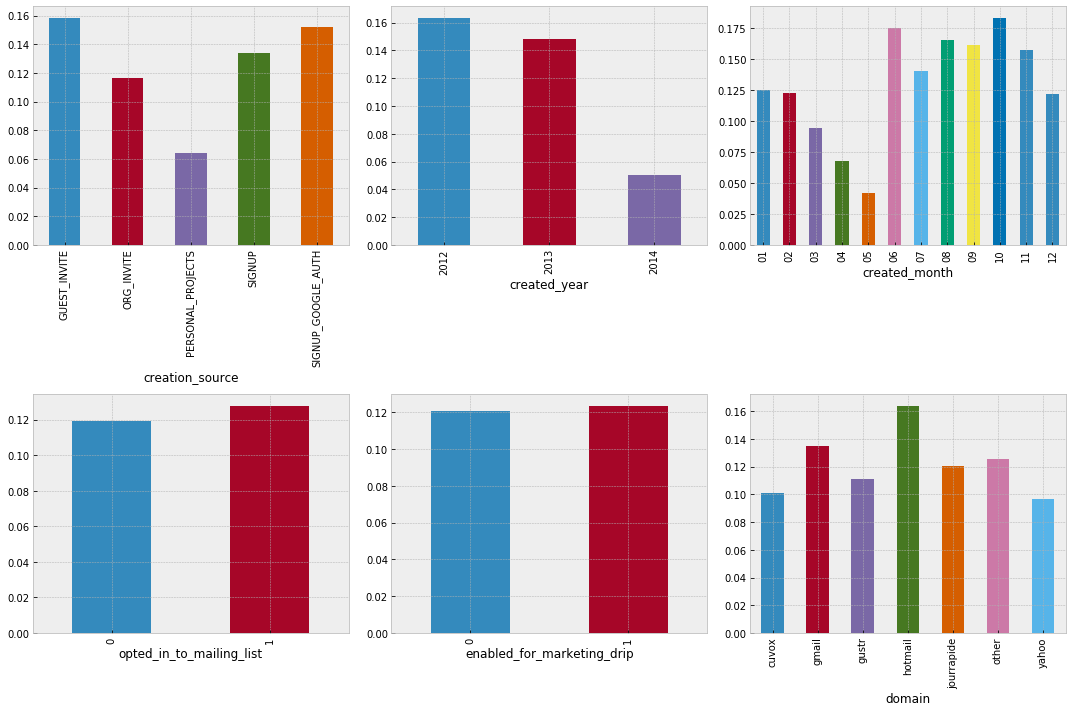

In [446]:
# Plotting out categorical data in bar plots
fig, axes = plt.subplots(nrows=2, ncols=3)
creation_source['ratio'].plot.bar(ax=axes[0,0], figsize=(15,10))
creation_year['ratio'].plot.bar(ax=axes[0,1], figsize=(15,10))
creation_month['ratio'].plot.bar(ax=axes[0,2], figsize=(15,10))
opted_in_to_mailing_list['ratio'].plot.bar(ax=axes[1,0], figsize=(15,10))
enabled_for_marketing_drip['ratio'].plot.bar(ax=axes[1,1], figsize=(15,10))
domain['ratio'].plot.bar(ax=axes[1,2], figsize=(15,10))
plt.tight_layout()
plt.savefig('ratios', dpi=500)
plt.show()

In [386]:
# Who are the best inviters?
org = users.groupby(['org_id', 'adopted']).count()['object_id'].unstack('adopted').rename(columns={0: 'No', 1:'Yes'})
org['ratio'] = org['Yes']/org['No']
print(org['ratio'].describe())
#top_org = org.sort_values(['ratio'], ascending=False)['ratio'].iloc[0:10]

invited_by_user_id = users.groupby(['invited_by_user_id', 'adopted']).count()['object_id'].unstack('adopted').rename(columns={0: 'No', 1:'Yes'}).dropna()
invited_by_user_id['ratio'] = invited_by_user_id['Yes']/invited_by_user_id['No']
print(org['ratio'].describe())
#top_invited_by_user_id = invited_by_user_id.sort_values(['ratio'], ascending=False)['ratio'].iloc[0:10]

count    393.000000
mean       0.157671
std        0.112613
min        0.020408
25%        0.085714
50%        0.130435
75%        0.190476
max        0.857143
Name: ratio, dtype: float64
count    393.000000
mean       0.157671
std        0.112613
min        0.020408
25%        0.085714
50%        0.130435
75%        0.190476
max        0.857143
Name: ratio, dtype: float64
